In [ ]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.auto import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
%load_ext autoreload
%autoreload 2
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../../figures/')

In [79]:
DATADIR = Path('/data/gpfs-1/users/peidlis_c/work/data/perturbation_resource_paper')
TEMPDIR = Path("/fast/scratch/users/peidlis_c/perturbation_resource_paper/")

def leftsided_chebyshev_nodes(N):
    # Takes negative chebyshev nodes of first kind, forces 0 to be included, then adds 1 to all.
    return np.polynomial.chebyshev.chebpts1(N*2+1)[:(N+1)] + 1

In [3]:
dataset = 'PapalexiSatija2021_eccite_RNA'
adata = sc.read(TEMPDIR / f'tmp_data_{dataset}.h5')

In [4]:
adata

AnnData object with n_obs × n_vars = 9400 × 15987
    obs: 'hto', 'guide_id', 'hto_barcode', 'gdo_barcode', 'perturbation', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'n_counts', 'perturbation_X'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
adata = sc.read(DATADIR / f'{dataset}.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 20729 × 18649
    obs: 'hto', 'guide_id', 'hto_barcode', 'gdo_barcode', 'perturbation', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [7]:
def equal_subsampling_(adata, obs_key, N_min=None):
    counts = adata.obs[obs_key].value_counts()
    groups = counts.index[counts>=N_min]  # ignore groups with less than N_min cells to begin with
    # We select downsampling target counts by min-max, i.e.
    # the largest N such that every group has at least N cells before downsampling.
    N = np.min(counts)
    N = N if N_min==None else np.max([N_min, N])
    # subsample indices per group
    indices = [np.random.choice(adata.obs_names[adata.obs[obs_key]==group], size=N if group!='control' else np.sum(adata.obs[obs_key]==group), replace=False) for group in groups]
    selection = np.hstack(np.array(indices))
    return adata[selection].copy()

In [8]:
# basic qc and pp
sc.pp.filter_cells(adata, min_counts=1000)
adata = equal_subsampling_(adata, 'perturbation', N_min=200)
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_per_cell(adata)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.log1p(adata)

Normalizing counts...
Applying log1p...
Shape after filtering:  (11586, 14881)
Selecting highly variable genes...
Running PCA...


# With recomputing HVG and PCA

In [74]:
N_eval = 20
xs = np.exp(np.linspace(np.log1p(5), np.log1p(np.sum(adata.obs.perturbation=='control')), N_eval))
xs = np.unique(np.array(xs, dtype=int))
xs = np.clip(xs, 0, np.sum(adata.obs.perturbation=='control'))
eds = {}
for x in tqdm(xs):
    idx = np.random.choice(adata.obs_names[adata.obs['perturbation']=='control'], size=x, replace=False)
    tdata = adata[list(idx)+list(adata.obs_names[adata.obs.perturbation!='control'])].copy()
    
    sc.pp.highly_variable_genes(tdata, n_top_genes=2000,
                                subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.pca(tdata, use_highly_variable=True, n_comps=50)
    eds[x] = edist_to_control(tdata, flavor=1, verbose=False)

100%|██████████| 20/20 [03:16<00:00,  9.80s/it]


In [75]:
ed = pd.concat(eds, axis=1)
ed.columns = ed.columns.droplevel(1)

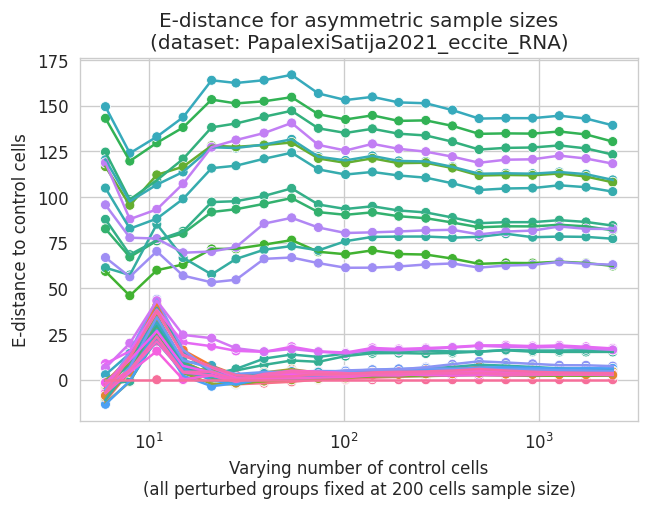

In [86]:
df = ed.unstack().reset_index()
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(1,1, dpi=120)
sns.lineplot(data=df, x='level_0', y=0, hue='perturbation', ax=ax)
sns.scatterplot(data=df, x='level_0', y=0, hue='perturbation', ax=ax)
ax.legend_.remove()
ax.set_xlabel('Varying number of control cells\n(all perturbed groups fixed at 200 cells sample size)')
ax.set_ylabel('E-distance to control cells')
ax.set_title(f'E-distance for asymmetric sample sizes\n(dataset: {dataset})')
ax.set_xscale('log')
pl.show()

# Without recomputing HVG and PCA

In [87]:
N_eval = 20

sc.pp.highly_variable_genes(adata, n_top_genes=2000,
                            subset=False, flavor='seurat_v3', layer='counts')
sc.pp.pca(adata, use_highly_variable=True, n_comps=50)

xs = np.exp(np.linspace(np.log1p(5), np.log1p(np.sum(adata.obs.perturbation=='control')), N_eval))
xs = np.unique(np.array(xs, dtype=int))
xs = np.clip(xs, 0, np.sum(adata.obs.perturbation=='control'))
eds = {}
for x in tqdm(xs):
    idx = np.random.choice(adata.obs_names[adata.obs['perturbation']=='control'], size=x, replace=False)
    tdata = adata[list(idx)+list(adata.obs_names[adata.obs.perturbation!='control'])].copy()
    eds[x] = edist_to_control(tdata, flavor=1, verbose=False)

100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


In [88]:
ed = pd.concat(eds, axis=1)
ed.columns = ed.columns.droplevel(1)

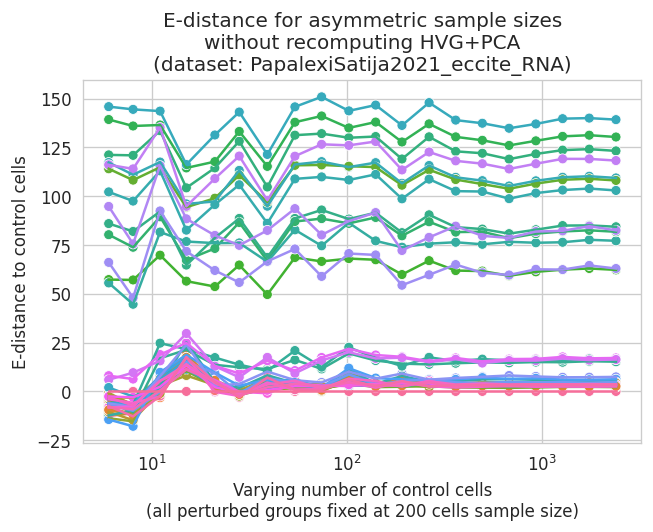

In [89]:
df = ed.unstack().reset_index()
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(1,1, dpi=120)
sns.lineplot(data=df, x='level_0', y=0, hue='perturbation', ax=ax)
sns.scatterplot(data=df, x='level_0', y=0, hue='perturbation', ax=ax)
ax.legend_.remove()
ax.set_xlabel('Varying number of control cells\n(all perturbed groups fixed at 200 cells sample size)')
ax.set_ylabel('E-distance to control cells')
ax.set_title(f'E-distance for asymmetric sample sizes\nwithout recomputing HVG+PCA\n(dataset: {dataset})')
ax.set_xscale('log')
pl.show()